In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
from sklearn import metrics
import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

device = torch.device('cpu')

Here we have semantic (or class) segmentation: we paint each front door as dark green, even if we have 5 or just 1 in the image (as opposed to instance segmentation, where we would assign a different color to each front door object/instance).

Useful links & resources:

- https://towardsdatascience.com/efficient-image-segmentation-using-pytorch-part-1-89e8297a0923
- https://www.tensorflow.org/tutorials/images/segmentation
- https://github.com/sheikhazhanmohammed/sadma
- https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics
- https://github.com/milesial/Pytorch-UNet
- https://github.com/asanakoy/kaggle_carvana_segmentation/tree/master

Pretrained models:

- https://pytorch.org/serve/model_zoo.html
- https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection

In [26]:
print("Started running car segmentation model.")
BATCH_SIZE = 64
ARRAYS_FOLDER = './arrays/'  # ARRAYS_FOLDER = 'carseg_data/arrays_rotated/'
NUM_CLASSES = 9

image_data_list = []
target_list = []


def one_hot_mask(mask):
    out = np.zeros((mask.size, NUM_CLASSES), dtype=np.float_)
    out[np.arange(mask.size), mask.ravel()] = 1
    out.shape = mask.shape + (NUM_CLASSES,)
    return out


npy_files = [f for f in os.listdir(ARRAYS_FOLDER) if f.endswith('.npy')]
for file in npy_files:
    file_path = os.path.join(ARRAYS_FOLDER, file)
    
    # Load the numpy array and normalize by dividing with the maximum value
    npy_file = np.load(file_path)

    image = torch.from_numpy(npy_file[:, :, 0:3]) / 255 # First 3 channels are the image data
    image = image.permute(2, 0, 1)  # Reshaping from HxWxC to CxHxW

    # Use this two lines to have a mask of the shape: CxHxW (Called probabilities in the documentation)
    # target = one_hot_mask((npy_file[:, :, 3] % 90) // 10) # Last channel is the mask and we prepare it for one_hot
    # target = torch.from_numpy(target).permute(2, 0, 1) # Reshaping from HxWxC to CxHxW

    # Use this line to have a mask of the shape: HxW (Called class indices, I think this is the correct way to go)
    target = torch.as_tensor((npy_file[:, :, 3] % 90) // 10, dtype=torch.long)

    image_data_list.append(image)
    target_list.append(target)

images_tensor = torch.stack(image_data_list, dim=0)
masks_tensor = torch.stack(target_list, dim=0)
dataset = TensorDataset(images_tensor, masks_tensor)

DATASET_LENGTH = len(dataset)
train_size = math.floor(DATASET_LENGTH * 0.8)
val_size = math.floor(DATASET_LENGTH * 0.1)
test_size = DATASET_LENGTH - train_size - val_size

generator_seed = torch.Generator().manual_seed(0)
train_set, temp_set = random_split(dataset, [train_size, val_size + test_size], generator=generator_seed)
val_set, test_set = random_split(temp_set, [val_size, test_size], generator=generator_seed)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        self.conv_block = nn.Sequential(
            # We use bias=False because it is somehow cancelled out by the batchnorm
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_block(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # output shape excluding channels (same for both height and width) is:
        # out = (in - 1) * stride - 2 * padding + (kernel_size - 1) + 1
        # here, with padding = 0, we get:
        # out = (stride * in) - (2 * stride) + kernel
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)  # x1 and x2 need to have the same number of rows, I think
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        # the CrossEntropyLoss automatically wraps this in a LogSoftmax, that's why we don't do it here
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.inc = (ConvBlock(3, 64, 64)) 
        self.down1 = (Down(64, 128)) 
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.down4 = (Down(512, 1024))
        self.up1 = (Up(1024, 512))
        self.up2 = (Up(512, 256))
        self.up3 = (Up(256, 128))
        self.up4 = (Up(128, 64))
        self.outc = (OutConv(64, NUM_CLASSES))

    def forward(self, x):
        x1 = self.inc(x)  # x1 HxW: 256x256
        x2 = self.down1(x1)  # x2 HxW: 128x128
        x3 = self.down2(x2)  # x3 HxW: 64x64
        x4 = self.down3(x3)  # x4 HxW: 32x32
        x5 = self.down4(x4)  # x5 HxW: 16x16
        x = self.up1(x5, x4)  # up(x5) gives 32x32, concat with x4, HxW remains 32x32 and the channels are added
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


# TODO: maybe here we want to use the dice coefficient instead? (torchmetrics.Dice ?)
# TODO: this needs a fix
def accuracy(outputs, targets):
    return 1


def dice_coeff(outputs, targets):
    # Assuming outputs and targets are tensors with shape (batch_size, num_classes, height, width)
    dice = torchmetrics.functional.dice(outputs.argmax(dim=1), targets.argmax(dim=1))
    return dice


def save_model(model, optimizer, save_path):
    state = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(state, save_path)
    print(f'Model saved at {save_path}')


def load_model(model, optimizer, load_path):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f'Model loaded from {load_path}')
    return model, optimizer


def evaluate_val_test_set(model, device, loss_fn, set_length, loader):
    with torch.no_grad():
        model.eval()
        set_loss = 0
        set_dice = 0
        for inputs, masks in loader:
            inputs, masks = inputs.to(device), masks.to(device)
            output = model(inputs)
            set_loss += loss_fn(output, masks).item()

            batch_dice = dice_coeff(output, masks)
            set_dice += batch_dice

        set_dice /= len(loader)
        set_loss /= math.ceil(set_length / BATCH_SIZE)
        return set_loss, set_dice



def train_model(model, epochs, optimizer, loss_fn, save_path):
    if not torch.cuda.is_available():
        print("CUDA NOT AVAILABLE!!!!")
    else:
        print("CUDA WORKING!!!")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    train_steps = math.ceil(len(train_set) / BATCH_SIZE)
    train_losses = []
    val_losses = []
    train_dices = []
    val_accuracies = []
    
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        epoch_dice = 0
        model.train()
        
        for step, (inputs, masks) in enumerate(train_loader, 1):
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            
            batch_loss = loss_fn(output, masks)
            batch_loss.backward()
            optimizer.step()
            epoch_loss += batch_loss.item()

            batch_dice = dice_coeff(output, masks)
            epoch_dice += batch_dice

        epoch_dice /= train_steps
        train_dices.append(epoch_dice)
        train_losses.append(epoch_loss / train_steps)

        val_loss, val_acc = evaluate_val_test_set(model, device, loss_fn, len(val_set), val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch train loss: {train_losses[-1]}, train accuracy: {train_dices[-1]}")
        print(f"Epoch validation loss: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}")

    if save_path is not None:
        save_model(model, optimizer, save_path)

    test_loss, test_acc = evaluate_val_test_set(model, device, loss_fn, len(test_set), test_loader)
    print(f"Test loss: {test_loss}, test accuracy: {test_acc}")

Started running car segmentation model.


Model loaded from model.pth
Accuracy: 0.99114990234375


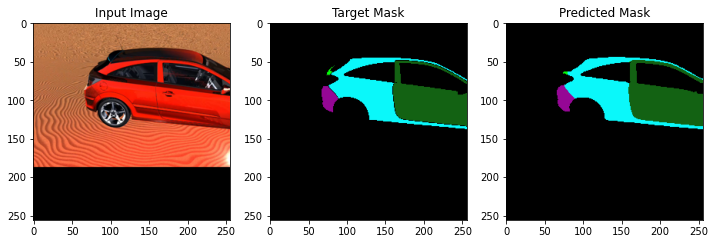

Accuracy: 0.993927001953125


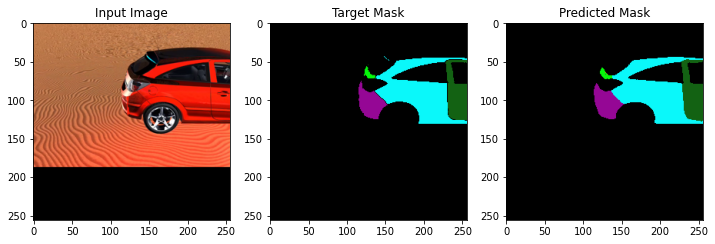

Accuracy: 0.86077880859375


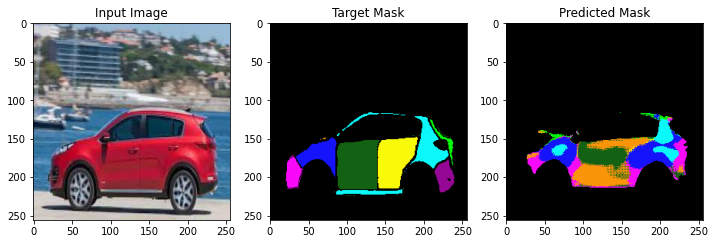

Accuracy: 0.99444580078125


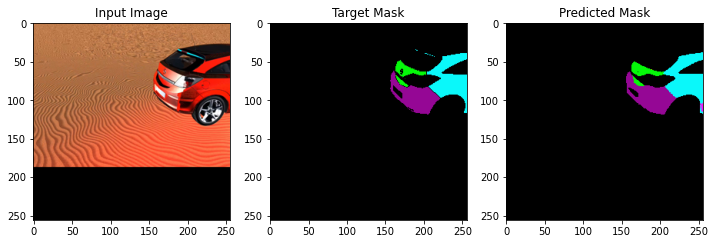

Accuracy: 0.98712158203125


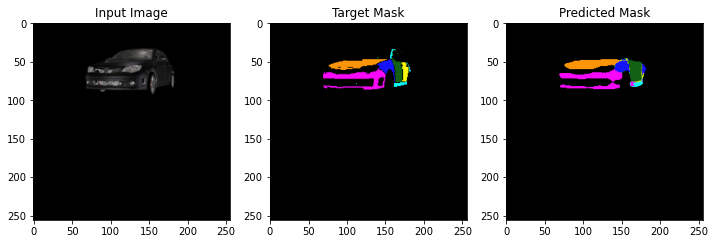

Accuracy: 0.990142822265625


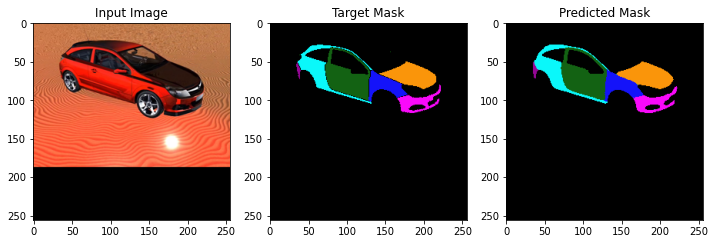

Accuracy: 0.986785888671875


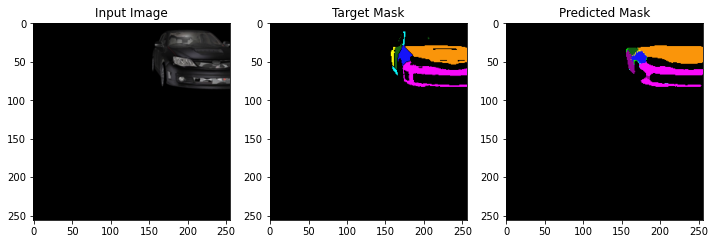

Accuracy: 0.9871978759765625


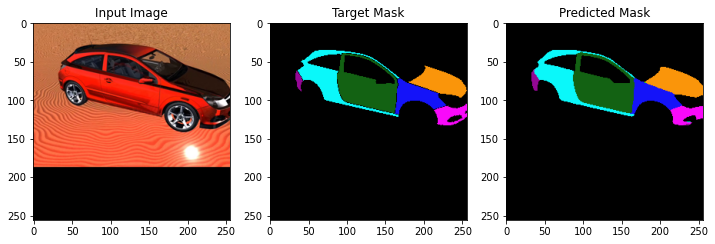

Accuracy: 0.9913177490234375


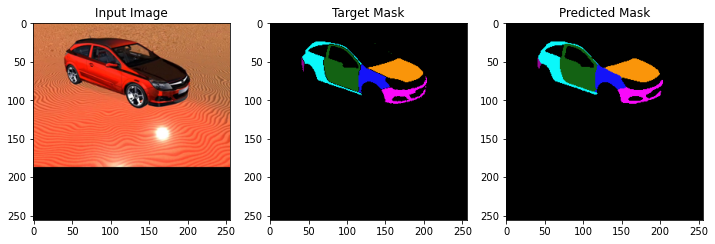

Accuracy: 0.9929351806640625


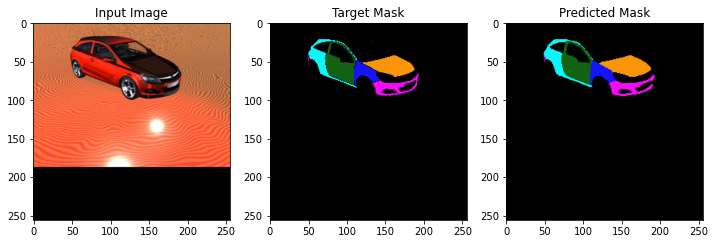

Accuracy: 0.9821929931640625


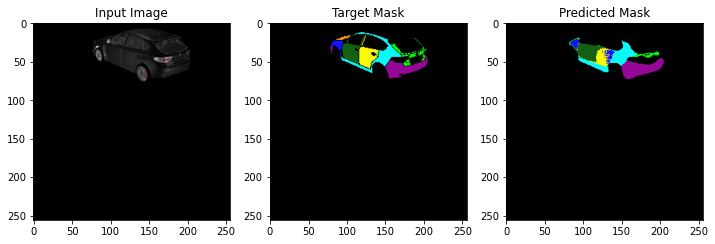

Accuracy: 0.9818267822265625


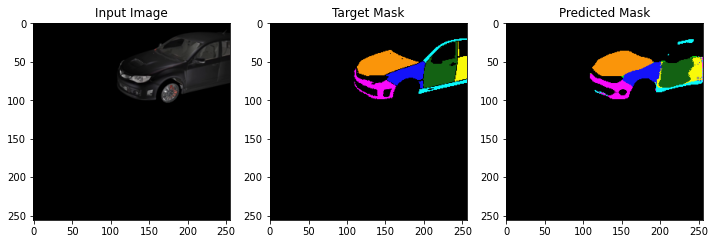

Accuracy: 0.9841156005859375


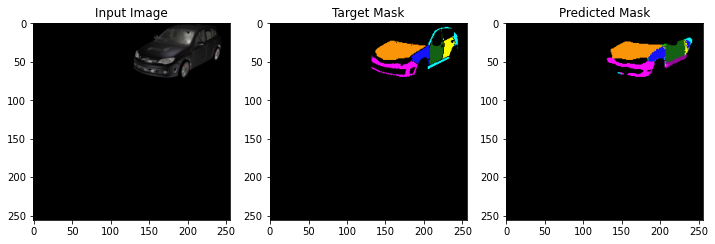

Accuracy: 0.9871063232421875


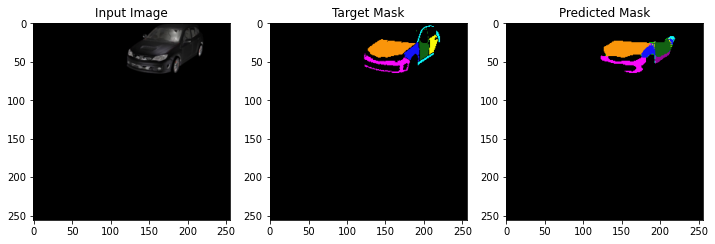

Accuracy: 0.7862548828125


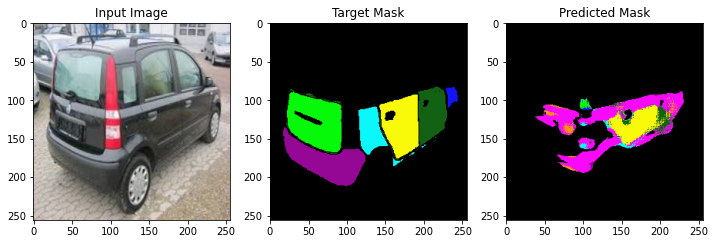

Accuracy: 0.9771881103515625


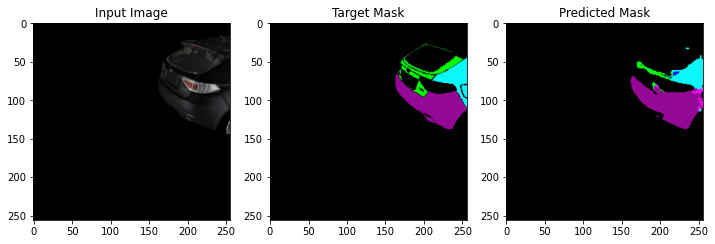

Accuracy: 0.8846435546875


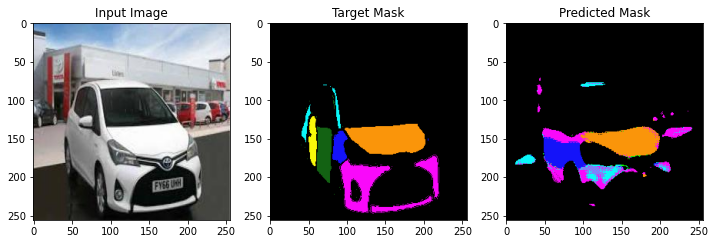

Accuracy: 0.990081787109375


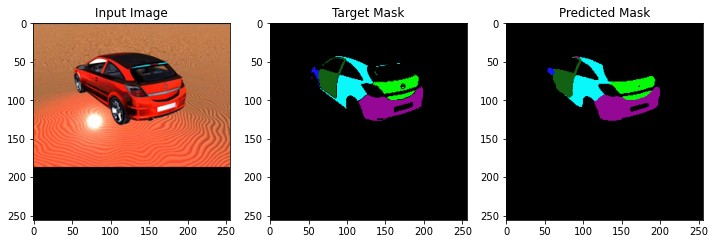

Accuracy: 0.9759368896484375


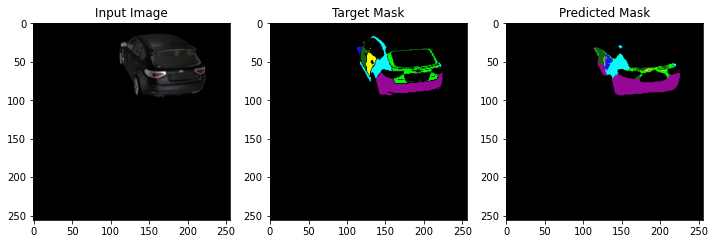

Accuracy: 0.9814605712890625


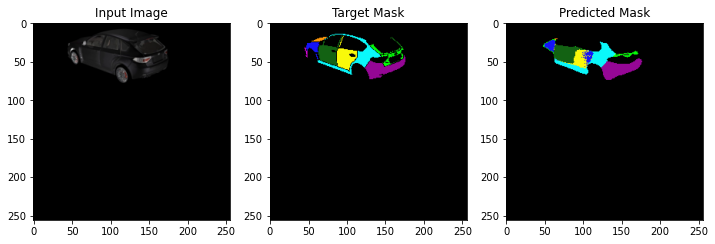

Accuracy: 0.9903717041015625


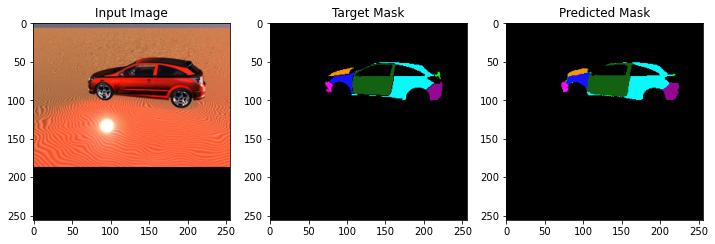

Accuracy: 0.9942779541015625


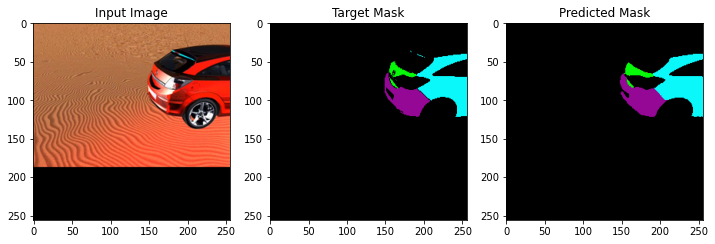

Accuracy: 0.994049072265625


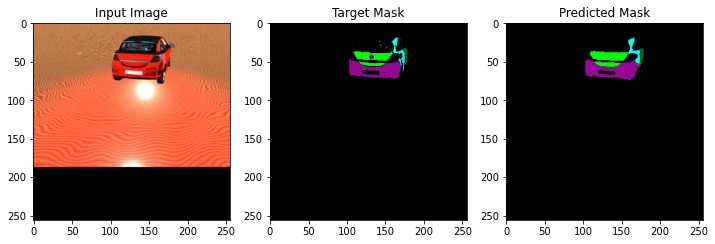

Accuracy: 0.967529296875


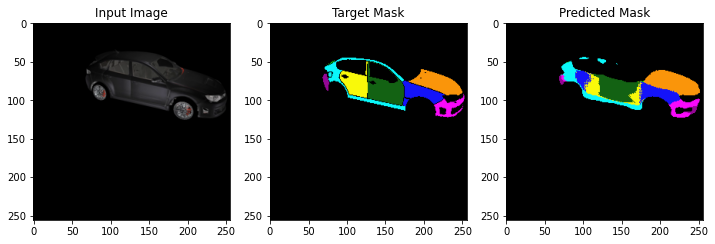

Accuracy: 0.979583740234375


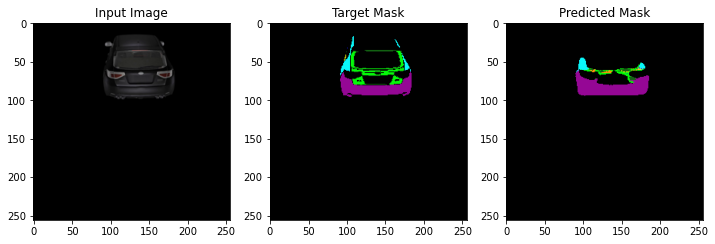

Accuracy: 0.9915924072265625


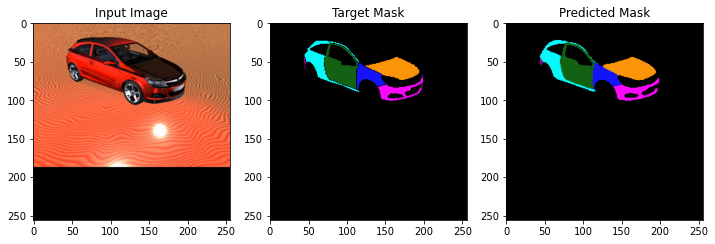

Accuracy: 0.9946441650390625


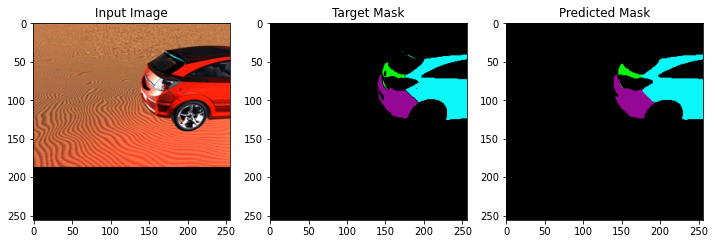

Accuracy: 0.990203857421875


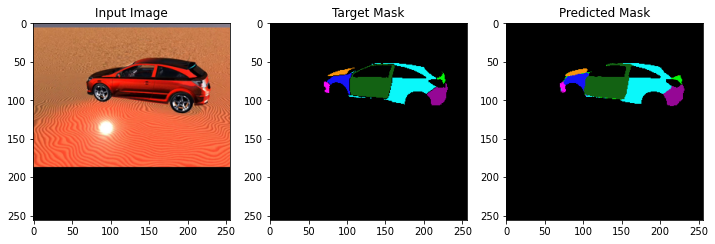

Accuracy: 0.992950439453125


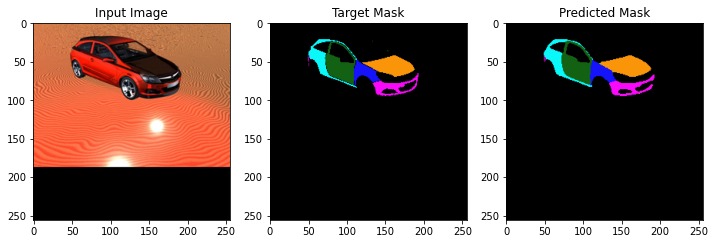

In [47]:
loaded_model = UNet()
loaded_optimizer = optim.Adam(loaded_model.parameters(), lr=1e-5, weight_decay=1e-4)
load_path = 'model.pth'
loaded_model, loaded_optimizer = load_model(loaded_model, loaded_optimizer, load_path)
loss = nn.LogSoftmax()

loaded_model.eval()
step = 0
with torch.no_grad():
    for input_image, target in test_set:
        step += 1
        if step == 30:
            break
        input_image = input_image.to(device)
        prediction = loaded_model(input_image.unsqueeze(0))
        prediction = prediction.argmax(dim=1)
        plt.figure(figsize=(12, 4))
        
        size = 256 * 256
        accuracy = (prediction[0] == target).sum() / size
        
        print(f'Accuracy: {accuracy}')

        plt.subplot(1, 3, 1)
        plt.imshow(input_image.squeeze().permute(1, 2, 0).cpu().numpy())
        plt.title('Input Image')

        plt.subplot(1, 3, 2)
        plt.imshow(map_npy_mask(target.cpu().numpy()))
        plt.title('Target Mask')

        plt.subplot(1, 3, 3)
        plt.imshow(map_npy_mask(prediction[0].cpu().numpy()))
        plt.title('Predicted Mask')

        plt.show()

### Segmentation class mappings (open cell to see better)

"color",        "description",          "class value",  "color values"
"orange",       "hood",                 10              (250, 149, 10)
"dark green",   "front door",           20              (19, 98, 19)
"yellow",       "rear door",            30              (249, 249, 10)
"cyan",         "frame",                40              (10, 248, 250)
"purple",       "rear quater panel",    50              (149, 7, 149)
"light green",  "trunk lid",            60              (5, 249, 9)
"blue",         "fender",               70              (20, 19, 249)
"pink",         "bumper",               80              (249, 9, 250)
"no color",     "rest of car",          90              NA

In [56]:
r_map = {0:0, 10: 250, 20: 19, 30: 249, 40: 10, 50: 149, 60: 5, 70: 20, 80: 249, 90: 0}
g_map = {0:0, 10: 149, 20: 98, 30: 249, 40: 248, 50: 7, 60: 249, 70: 19, 80: 9, 90: 0}
b_map = {0:0, 10: 10, 20: 19, 30: 10, 40: 250, 50: 149, 60: 9, 70: 249, 80: 250, 90: 0}

def map_r_pixel(current_pixel):
    return r_map[current_pixel * 10]

def map_g_pixel(current_pixel):
    return g_map[current_pixel * 10]

def map_b_pixel(current_pixel):
    return b_map[current_pixel * 10]


map_r_pixel_vec = np.vectorize(map_r_pixel, otypes=['uint8'])
map_g_pixel_vec = np.vectorize(map_g_pixel, otypes=['uint8'])
map_b_pixel_vec = np.vectorize(map_b_pixel, otypes=['uint8'])

def map_npy_mask(original_mask):
    mapped_r = map_r_pixel_vec(original_mask)
    mapped_g = map_g_pixel_vec(original_mask)
    mapped_b = map_b_pixel_vec(original_mask)
    output = np.stack([mapped_r, mapped_g, mapped_b], axis=2)
    return output

In [ ]:
NUM_CLASSES = 9
def one_hot_mask(mask):
    out = np.zeros((mask.size, NUM_CLASSES), dtype=np.float_)
    out[np.arange(mask.size), mask.ravel()] = 1
    out.shape = mask.shape + (NUM_CLASSES,)
    return out


npy_file = np.load("./arrays/black_5_doors_0001.npy")
target = (npy_file[:, :, 3] % 90) // 10
output = one_hot_mask(target)
print(output.shape, output.max(), np.unique(output))

# Mapping function test
for row in range(len(target)):
    for col in range(len(target[0])):
        element = target[row][col]
        element_output = output[row][col]
        if element_output.sum() != 1 or element_output[element] != 1:
            print(row, col, element, element_output)

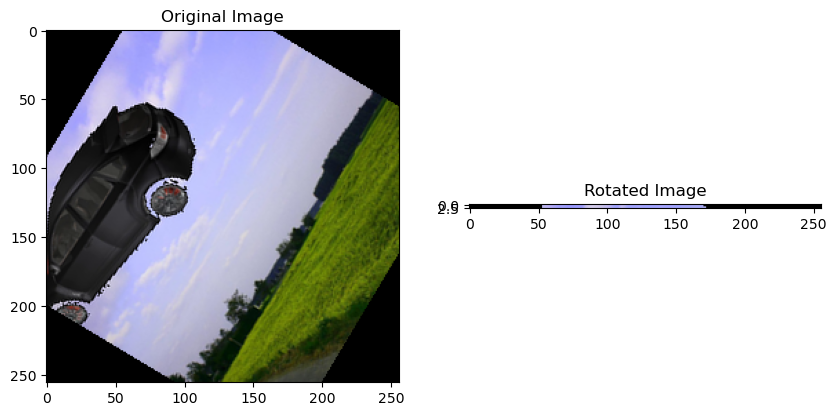

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

ROTATED_FOLDER = 'carseg_data/arrays_rotated/'

def load_random_example(folder):
    rotated_files = [f for f in os.listdir(folder) if f.endswith('.npy')]

    if not rotated_files:
        raise ValueError("No rotated examples found in the folder.")

    random_file = np.random.choice(rotated_files)
    file_path = os.path.join(folder, random_file)

    # Load the rotated example
    rotated_example = np.load(file_path)

    return rotated_example

def display_example(original_image, rotated_image):
    plt.figure(figsize=(10, 5))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image[:, :, :3])  # Display only RGB channels
    plt.title('Original Image')

    # Display the rotated image
    plt.subplot(1, 2, 2)
    plt.imshow(rotated_image[:, :, :3])  # Display only RGB channels
    plt.title('Rotated Image')

    plt.show()

def main():
    try:
        rotated_example = load_random_example(ROTATED_FOLDER)
        original_image = rotated_example[:, :, :3]  # Extract RGB channels
        target = rotated_example[3:6, :, :]  # Extract target values
        rotated_image = rotate(original_image, angle=0, reshape=False)

        # Display the example
        display_example(original_image, target)

    except ValueError as e:
        print(e)

%matplotlib inline

if __name__ == "__main__":
    main()
